In [1]:
!conda config --add channels conda-forge
!conda install -y --update-dependencies fenics mshr matplotlib

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /srv/conda:

The following NEW packages will be INSTALLED:

    blas:             1.1-openblas                          conda-forge
    boost:            1.67.0-py36h3e44d54_0                 conda-forge
    boost-cpp:        1.67.0-h3a22d5f_0                     conda-forge
    bzip2:            1.0.6-h470a237_2                      conda-forge
    cloog:            0.18.0-0                              defaults   
    cmake:            3.11.4-0                              conda-forge
    curl:             7.61.0-h93b3f91_1                     conda-forge
    cycler:           0.10.0-py_1                           conda-forge
    dbus:             1.13.0-h3a4f0e9_0                     conda-forge
    eigen:            3.3.5-0                               conda-forge
    expat:            2.2.5-hfc679d8_1                      conda-forge
    fastcache:        1.0.2-

hypre-2.14.0-h 100% |################################| Time: 0:00:00  13.42 MB/s
libssh2-1.8.0- 100% |################################| Time: 0:00:00  38.39 MB/s
libxcb-1.13-h4 100% |################################| Time: 0:00:00  13.92 MB/s
libxml2-2.9.8- 100% |################################| Time: 0:00:00  12.93 MB/s
mpc-1.1.0-4.ta 100% |################################| Time: 0:00:00  37.70 MB/s
parmetis-4.0.3 100% |################################| Time: 0:00:00  33.85 MB/s
ptscotch-6.0.5 100% |################################| Time: 0:00:00   3.71 MB/s
scalapack-2.0. 100% |################################| Time: 0:00:00  15.95 MB/s
curl-7.61.0-h9 100% |################################| Time: 0:00:00  15.44 MB/s
fontconfig-2.1 100% |################################| Time: 0:00:00  16.08 MB/s
gcc-4.8.5-7.ta 100% |################################| Time: 0:00:02  33.56 MB/s
gstreamer-1.8. 100% |################################| Time: 0:00:00  15.32 MB/s
mumps-mpi-5.1. 100% |#######

rve
press
block
sparse


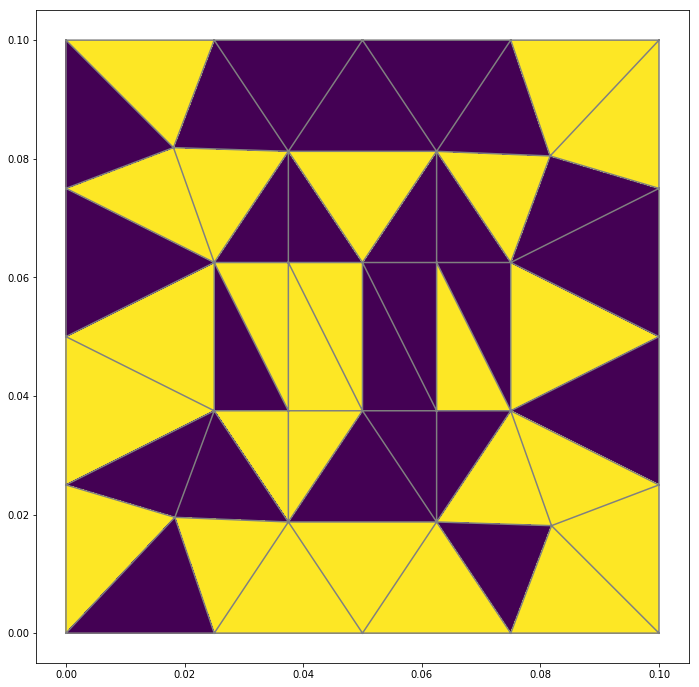

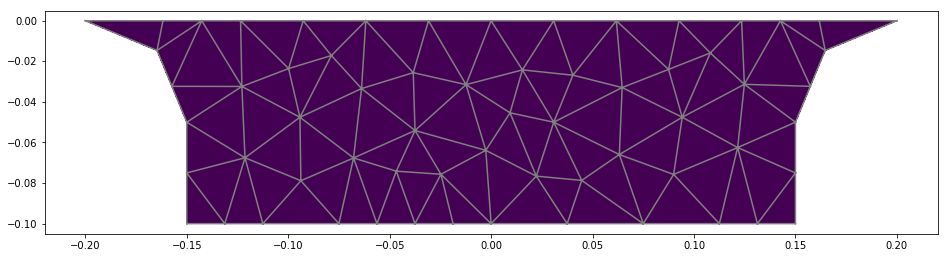

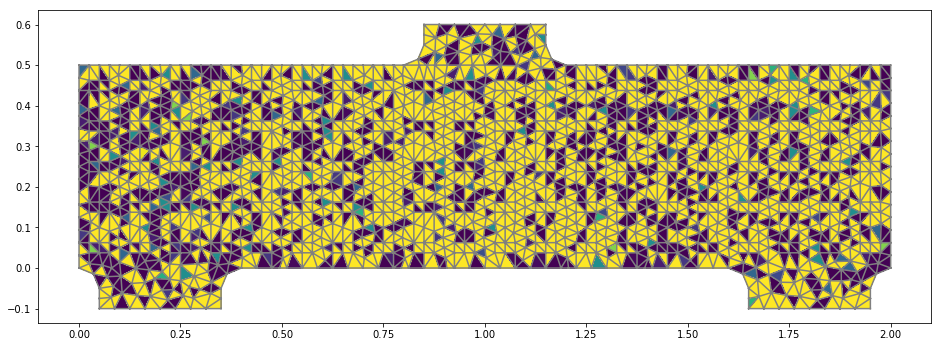

In [ ]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

def Fiber(w, h, x, y):
    domain = Rectangle(Point(x - w/2, y - h/2), Point(x + w/2, y + h/2))
    return domain

def Composite(w, h, fw, fh, dx, dy, add=None):
    domain = Rectangle(Point(0, 0), Point(w, h))
    if not add is None:
        domain += add
    nx = int(w / dx)
    ny = int(h / dy)
    for i in range(nx):
        x = w * (i + 0.5) / nx 
        for j in range(ny):
            y = h * (j + 0.5) / ny
            domain.set_subdomain(i * ny + j + 1, Fiber(fw, fh, x, y))
    return domain

def Press(w, h, rx, ry, s):
    domain = Rectangle(Point(-w/2, -h), Point(w/2, 0)) \
           - Ellipse(Point(-w/2, -ry), rx, ry, s) \
           - Ellipse(Point(w/2, -ry), rx, ry, s) \
           - Rectangle(Point(-w/2, -h), Point(-w/2 + rx, -ry)) \
           - Rectangle(Point(w/2 - rx, -h), Point(w/2, -ry))
    return domain
    
def Block(w, h, fw, fh, dx, dy, p, pw):
    presses = CSGTranslation(p, Point(pw/2, 0)) \
            + CSGTranslation(p, Point(w-pw/2, 0)) \
            + CSGTranslation(CSGRotation(p, DOLFIN_PI), Point(w/2, h))
    domain = Composite(w, h, fw, fh, dx, dy, presses)
    return domain

def SparseBlock(w, h, fw, fh, dx, dy, p, pw, rvew, rveh):
    p = p + Rectangle(Point(-pw/2, 0), Point(pw/2, rveh))
    presses = CSGTranslation(p, Point(pw/2, 0)) \
            + CSGTranslation(p, Point(w-pw/2, 0)) \
            + CSGTranslation(CSGRotation(p, DOLFIN_PI), Point(w/2, h))
    domain = Rectangle(Point(0, 0), Point(w, h)) + presses
    domain.set_subdomain(1, presses)
    nx = int(w / dx)
    ny = int(h / dy)
    for i in range(nx):
        x = w * (i + 0.5) / nx 
        for j in range(ny):
            y = h * (j + 0.5) / ny
            if near(x, pw/2, pw/2) and near(y, 0, rveh) \
            or near(x, w-pw/2, pw/2) and near(y, 0, rveh) \
            or near(x, w/2, pw/2) and near(y, h, rveh):
                domain.set_subdomain(i * ny + j + 2, Fiber(fw, fh, x, y))
    return domain

def save(geo, name, resolution, do_plot=False):
    mesh = generate_mesh(geo, resolution)
    domains = MeshFunction("size_t", mesh, 2, mesh.domains())
    File("meshes/" + name + ".xml") << mesh
    File("meshes/" + name + "_domains.xml") << domains
    File("meshes/" + name + "_domains.pvd") << domains
    if do_plot:
        plt.figure(figsize=(16, 12))
        plot(mesh)
        plot(domains)
    

fiberWidth  = 0.05
fiberHeight = 0.025
densityX    = 0.1
densityY    = 0.1
rveWidth    = 0.1
rveHeight   = 0.1
blockWidth  = 2.0
blockHeight = 0.5
pressWidth  = 0.4
pressHeight = 0.1
roundX      = 0.05
roundY      = 0.05
resolution  = 40
coarse      = 20
segments    = 8

#parameters["lloyd_optimize"] = True
#parameters["mesh_resolution"] = resolution
#parameters["edge_truncate_tolerance"] = 1e-16

print("rve")
rve = Composite(rveWidth, rveHeight, fiberWidth, fiberHeight, densityX, densityY)
save(rve, "rve", sqrt(rveWidth*rveHeight)*resolution, True)

print("press")
press = Press(pressWidth, pressHeight, roundX, roundY, segments)
save(press, "press", sqrt(pressWidth*pressHeight)*resolution, True)

print("block")
block = Block(blockWidth, blockHeight, fiberWidth, fiberHeight, densityX, densityX, press, pressWidth)
save(block, "block", sqrt(blockWidth*blockHeight)*resolution, True)

print("sparse")
sparse = SparseBlock(blockWidth, blockHeight, fiberWidth, fiberHeight, densityX, densityX, press, pressWidth, rveWidth, rveHeight)
save(sparse, "sparse", sqrt(blockWidth*blockHeight)*coarse, True)

